# Semantic segmentation of dermoscopy images using SegNet, UNet models and different loss functions

## ADDI dataset

[ADDI](https://www.fc.up.pt/addi/project.html) is a multidisciplinary project that joins medical doctors from the Pedro Hispano Hospital and academic researchers from different fields of Engineering and Mathematics from the University of Porto, University of Aveiro and Instituto Superior Técnico. The driving force for this research proposal was the several years of experience in dermoscopy, tele-dermoscopy and telemedicine at the HPH Service of Dermatology, and the lack of an efficient automatic image analysis system for dermoscopic images. 


- Teresa Mendonça, Pedro M. Ferreira, Jorge Marques, Andre R. S. Marcal, Jorge Rozeira. PH² - A dermoscopic image database for research and benchmarking, 35th International Conference of the IEEE Engineering in Medicine and Biology Society, July 3-7, 2013, Osaka, Japan.

<table><tr><td>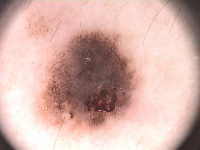</td><td>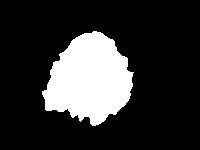</td></tr></table>



In [1]:
import os
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_hyperlight import Runner
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import DataLoader

In [2]:
if not Path('./PH2Dataset.rar').is_file():
    !wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
    !unrar x PH2Dataset.rar

In [3]:
FAST_DEV_RUN = False

In [4]:
# Parameters
FAST_DEV_RUN = False


In [5]:
EXPERIMENT_ID = "Semantic_Segmentation_PH2"

In [6]:
NUM_WORKERS = 6

In [7]:
IS_CUDA = torch.cuda.is_available()

These are auxilary functions, we will use them later to generate reports

In [8]:
images = []
lesions = []
root = "PH2Dataset"

for root, dirs, files in os.walk(os.path.join(root, "PH2 Dataset images")):
    if root.endswith("_Dermoscopic_Image"):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith("_lesion"):
        lesions.append(imread(os.path.join(root, files[0])))

In [9]:
IMAGE_SIZE = (256, 256)
X = [
    resize(
        x,
        IMAGE_SIZE,
        mode="constant",
        anti_aliasing=True,
    )
    for x in images
]
Y = [resize(y, IMAGE_SIZE, mode="constant", anti_aliasing=False) > 0.5 for y in lesions]

In [10]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f"Loaded {len(X)} images")

Loaded 200 images


In [11]:
len(lesions)

200

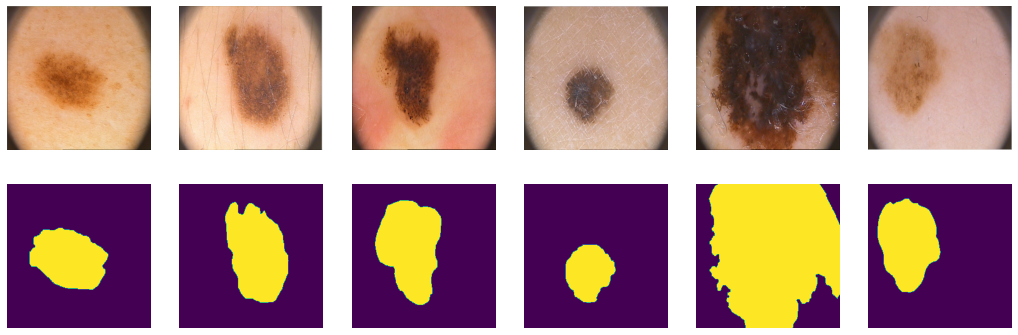

In [12]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i + 7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()

#### PyTorch DataLoader

PyTorch Hyperlight requires dataloaders to be returned as a dictionary from a function

In [13]:
def configure_dataloaders(batch_size, n_workers=4, val_size=0.2):

    ix = np.random.choice(len(X), len(X), False)
    tr, val, ts = np.split(ix, [100, 150])
    loaders = {
        "train": DataLoader(
            list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
            batch_size=batch_size,
            shuffle=True,
            num_workers=n_workers,
        ),
        "valid": DataLoader(
            list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
            batch_size=batch_size,
            shuffle=False,
            num_workers=n_workers,
        ),
        "test": DataLoader(
            list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
            batch_size=batch_size,
            shuffle=False,
            num_workers=n_workers,
        ),
    }
    return loaders

## Auxilary classes
Let us define a few classes that we are going to re-use for different models and loss functions

```CustomLoss``` class is PyTorch module a wrapper for our loss function

In [14]:
class CustomLoss(nn.Module):
    def __init__(self, f_loss):
        super().__init__()

        self.f_loss = f_loss

    def forward(self, logits, targets):
        return self.f_loss(logits, targets)

```LitMetricsCalc``` will be responsible for metrics logging

In [15]:
class LitMetricsCalc(torch.nn.Module):
    def __init__(self, prefix):
        super(LitMetricsCalc, self).__init__()
        self.prefix = prefix

    def step(self, logit, target):
        prefix = self.prefix
        iou_batch_score = iou_pytorch(logit > 0, target).mean().item()
        return {
            f"{prefix}_iou": iou_batch_score,
        }

```SegmentationTask``` PyTorch-Lightning module that we will use as a base class for our model-specific Lightning modules

In [16]:
class SegmentationTask(pl.LightningModule):
    def __init__(self, hparams, model, criterion):
        super().__init__()
        self.hparams = hparams
        #
        self.model = model
        self.criterion = criterion
        self.train_metric_calc = LitMetricsCalc("train")
        self.val_metric_calc = LitMetricsCalc("val")
        self.test_metric_calc = LitMetricsCalc("test")

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, self.hparams.lr_step_epochs, self.hparams.lr_step_factor
        )
        return [optimizer], [
            {"scheduler": scheduler, "interval": "epoch", "frequency": 1}
        ]

    def forward(self, inputs):

        logits = self.model(inputs)

        return logits

    def forward_batch(self, batch):
        inputs = batch[0]
        return self(inputs)

    def __calc_loss(self, logits, target, log_label):
        loss = self.criterion(logits, target)
        self.log(f"{log_label}_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def __stage_step(self, metric_calc, batch, batch_idx, stage):
        logits = self.forward_batch(batch)
        mval_dict = metric_calc.step(logits, batch[1])
        self.log_dict(mval_dict, prog_bar=True, on_step=True, on_epoch=True)
        loss = self.__calc_loss(logits, batch[1], stage)
        return loss

    def training_step(self, batch, batch_idx):
        return self.__stage_step(self.train_metric_calc, batch, batch_idx, "train")

    def test_step(self, batch, batch_idx):
        return self.__stage_step(self.test_metric_calc, batch, batch_idx, "test")

    def validation_step(self, batch, batch_idx):
        return self.__stage_step(self.val_metric_calc, batch, batch_idx, "val")

## SegNet


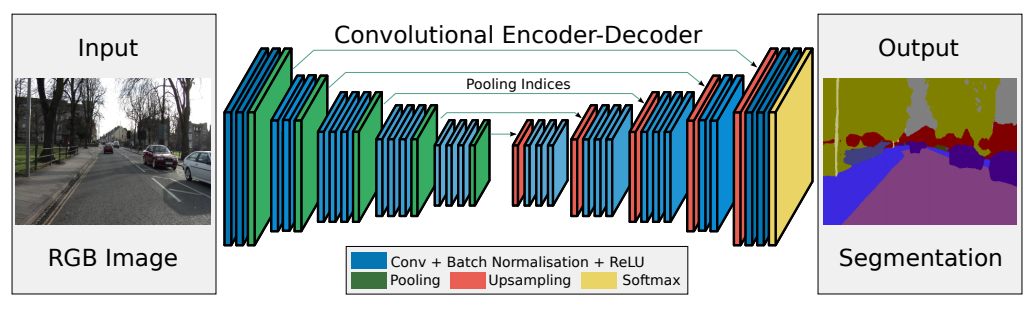

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [17]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=32,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        self.pool0 = nn.MaxPool2d(
            kernel_size=2, stride=2, padding=0, return_indices=True
        )  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.pool1 = nn.MaxPool2d(
            kernel_size=2, stride=2, padding=0, return_indices=True
        )  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.pool2 = nn.MaxPool2d(
            kernel_size=2, stride=2, padding=0, return_indices=True
        )  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=512,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        self.pool3 = nn.MaxPool2d(
            kernel_size=2, stride=2, padding=0, return_indices=True
        )  # 32 -> 16

        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(
                in_channels=512,
                out_channels=128,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.upsample1 = nn.MaxUnpool2d(2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=64,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=32,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=(3, 3),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        self.upsample3 = nn.MaxUnpool2d(2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=(1, 1),
            ),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(
                in_channels=32,
                out_channels=1,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=(1, 1),
            ),
        )

    def forward(self, x):
        # encoder
        e0, e0_mp_ind_vec = self.pool0(self.enc_conv0(x))
        e1, e1_mp_ind_vec = self.pool1(self.enc_conv1(e0))
        e2, e2_mp_ind_vec = self.pool2(self.enc_conv2(e1))
        e3, e3_mp_ind_vec = self.pool3(self.enc_conv3(e2))

        e3 = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(e3, e3_mp_ind_vec))
        d1 = self.dec_conv1(self.upsample1(d0, e2_mp_ind_vec))
        d2 = self.dec_conv2(self.upsample2(d1, e1_mp_ind_vec))
        d3 = self.dec_conv3(self.upsample3(d2, e0_mp_ind_vec))  # no activation
        return d3

## Jaccard index (IoU) for prediction evaluation

We will use IoU metric as a measure of model's quality

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [18]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (
        (outputs & labels).float().sum((1, 2))
    )  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))  # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (
        union + SMOOTH
    )  # We smooth our devision to avoid 0/0

    thresholded = (
        torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    )  # This is equal to comparing with thresolds

    return thresholded  #

## BCELoss

Using IoU as a loss function is not a good idea because a) IoU is not differentiable and b) it has a plateau when sets do not intersect. Thus we need to use a different function as a loss. One of popular loss functions for binary semantic segmentation is

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

where $y$ is a target and $\hat y$ is a prediction. $\sigma$. The formula above is not numerically stable as $\lim_{x\rightarrow0}\log(x)=\infty$ prevents a good convergence. That is why an equivalent representation(see https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) 

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

is used to improve numerical stability around zero.

In [19]:
def bce_loss(y_hat, y):
    return (y_hat - y * y_hat + torch.log(1 + torch.exp(-y_hat))).mean()

Let us define the hyper-parameters for our model.

In [20]:
CONFIG = {
    "lr": 3e-4,  # Initial learning rate
    "lr_step_epochs": 15,  # for StepLR LR scheduler
    "lr_step_factor": 0.1,  # for StepLR LR scheduler
    "gradient_clip_val": 0,
    "max_epochs": 50,  # the actual number can be less due to early stopping
    "batch_size": 40,  # the maximum for this model and RTX 2070,
}

And some extra parameters required for training

In [21]:
GPU_PER_TRIAL = 0.5 * IS_CUDA

In [22]:
TUNE_CONFIG = {
    "seed": 17,
    "metric_to_optimize": "val_iou_epoch",  # Ray + PTL Trainer
    "ray_metrics_to_show": [
        "val_loss_epoch",
        "val_iou_epoch",
    ],  # Ray
    "metric_opt_mode": "max",  # Ray + PTL Trainer
    "cpu_per_trial": NUM_WORKERS,  # Ray + DataLoaders
    "gpu_per_trial": GPU_PER_TRIAL,  # Ray
    "n_checkpoints_to_keep": 1,  # Ray
    "epoch_upper_limit": 45,  # Ray
    "n_samples": 40,  # Ray
    # "n_samples": 3,
    "ptl_early_stopping_patience": 3,  # PTL Trainer
    "grace_period": 14,  # PTL Trainer
    "ptl_precision": 16 if IS_CUDA else 32,  # PTL Trainer
    #
    "train_loader_name": "train",
    "val_loader_name": "valid",
    "test_loader_name": "test",
    #
    "batch_size_main": CONFIG[
        "batch_size"
    ],  # batch size for validation runs in the main process once all Ray Tune trials are finished
    "gpus": -1 * IS_CUDA,
}

if FAST_DEV_RUN:
    CONFIG["max_epochs"] = 2
    TUNE_CONFIG["n_samples"] = 2

In [23]:
runner = Runner(
    configure_dataloaders,
    is_debug=FAST_DEV_RUN,
    experiment_id=EXPERIMENT_ID,
    log2wandb=False
)

In [24]:
best_results_dict = {}

Let us define our first PyTorch Lightning module by injecting the BCE loss into SegNet model into SegmentationTask constructor

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 17
Global seed set to 17

  | Name              | Type           | Params
-----------------------------------------------------
0 | model             | SegNet         | 9.2 M 
1 | criterion         | CustomLoss     | 0     
2 | train_metric_calc | LitMetricsCalc | 0     
3 | val_metric_calc   | LitMetricsCalc | 0     
4 | test_metric_calc  | LitMetricsCalc | 0     
-----------------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

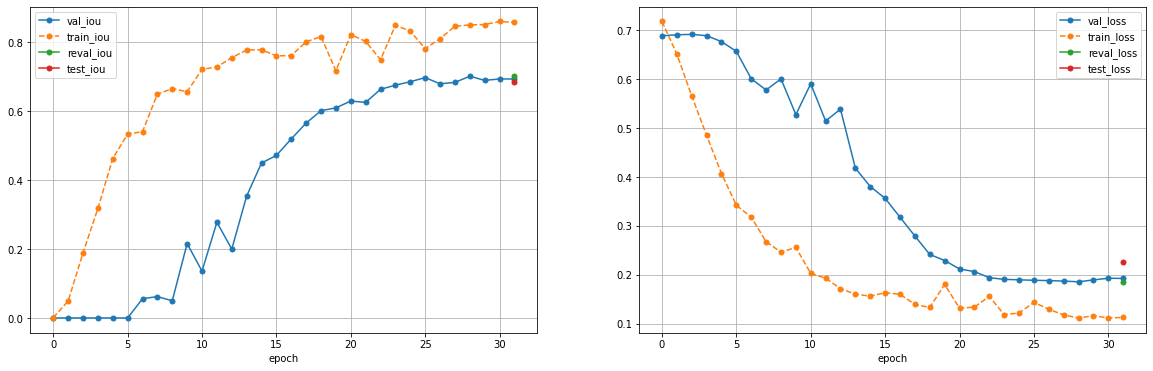

Global seed set to 17


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 17


In [25]:
class SegmentationSegNetBCE(SegmentationTask):
    def __init__(self, hparams):
        model = SegNet()
        criterion = CustomLoss(bce_loss)
        super().__init__(hparams, model, criterion)


best_result = runner.run_single_trial(
    SegmentationSegNetBCE, CONFIG, TUNE_CONFIG
)

## DICE coefficient

$IoU(X,Y)$ is not differentiable as a function of two sets $X$ and $Y$. We can, however, consider its approximations that are differentiable.

One of such approximations is DICE coefficient defined as

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

In [26]:
def dice_loss(y_hat, y):
    y_hat = torch.sigmoid(y_hat)
    epsilon = 1e-7
    axes = tuple(range(1, len(y_hat.shape) - 1))
    num = torch.sum(2.0 * y_hat * y, axes)
    den = torch.sum(y_hat + y, axes)
    res = torch.mean(1 - (num + epsilon) / (den + epsilon))
    return res

Let us train the model

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 17
Global seed set to 17

  | Name              | Type           | Params
-----------------------------------------------------
0 | model             | SegNet         | 9.2 M 
1 | criterion         | CustomLoss     | 0     
2 | train_metric_calc | LitMetricsCalc | 0     
3 | val_metric_calc   | LitMetricsCalc | 0     
4 | test_metric_calc  | LitMetricsCalc | 0     
-----------------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

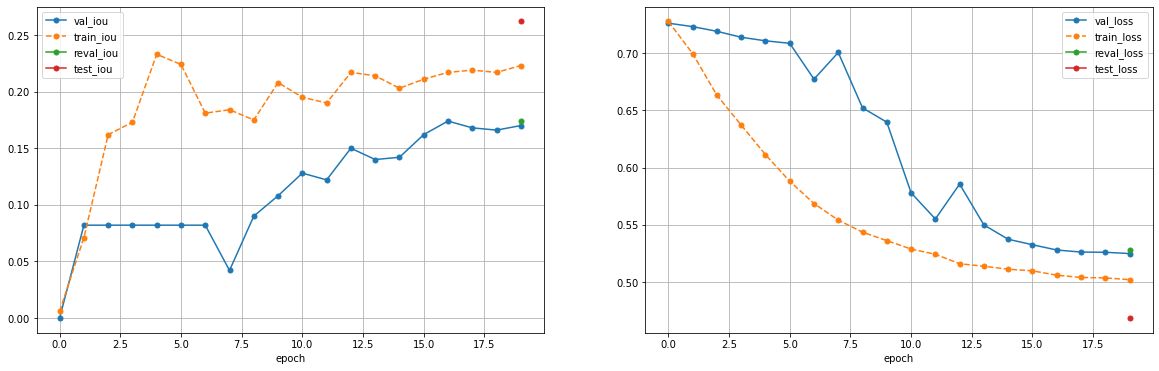

Global seed set to 17


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 17


In [27]:
class SegmentationSegNetDICE(SegmentationTask):
    def __init__(self, hparams):
        model = SegNet()
        criterion = CustomLoss(dice_loss)
        super().__init__(hparams, model, criterion)


best_result = runner.run_single_trial(
    SegmentationSegNetDICE, CONFIG, TUNE_CONFIG
)

## Focal loss
Focal loss (see ["Focal Loss for Dense Object Detection" by Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kaiming He, Piotr Doll, Facebook AI Research (FAIR), 2018"](https://arxiv.org/pdf/1708.02002.pdf)) defined as

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

tries to make BCELoss more balanced by by weighting each pixel by the prediction "certainty" level.

In [28]:
def focal_loss(y_hat, y, eps=1e-8, gamma=2):
    bce = (
        torch.max(y_hat, torch.zeros_like(y_hat))
        - y * y_hat
        + torch.log(1 + torch.exp(-torch.abs(y_hat)))
    )
    your_loss = (
        1 - y * torch.sigmoid(y_hat) - (1 - y) * (1 - torch.sigmoid(y_hat))
    ) ** gamma * bce
    return torch.clamp(your_loss.mean(), min=0)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 17
Global seed set to 17

  | Name              | Type           | Params
-----------------------------------------------------
0 | model             | SegNet         | 9.2 M 
1 | criterion         | CustomLoss     | 0     
2 | train_metric_calc | LitMetricsCalc | 0     
3 | val_metric_calc   | LitMetricsCalc | 0     
4 | test_metric_calc  | LitMetricsCalc | 0     
-----------------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

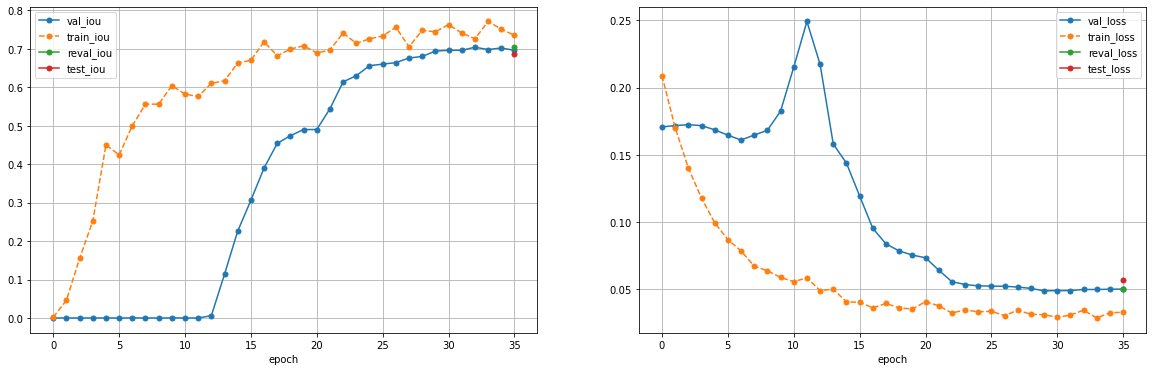

Global seed set to 17


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 17


In [29]:
class SegmentationSegNetFocal(SegmentationTask):
    def __init__(self, hparams):
        model = SegNet()
        criterion = CustomLoss(focal_loss)
        super().__init__(hparams, model, criterion)


best_result = runner.run_single_trial(
    SegmentationSegNetFocal, CONFIG, TUNE_CONFIG
)

## Fuzzy IoU


Let us try to implement IoU in a way that allows to minimize it direction without any need for a proxy loss function. 
Accoding to
 - ["Optimizing Intersection-Over-Union in DeepNeural Networks for Image Segmentation", Md Atiqur Rahman and Yang Wang, 2016](http://cs.umanitoba.ca/~ywang/papers/isvc16.pdf) 
 - ["UnitBox: An Advanced Object Detection Network" by Jiahui Yu, Yuning Jiang, Zhangyang Wang, Zhimin Cao, Thomas Huan, 2016](https://arxiv.org/pdf/1608.01471.pdf)
 
IoU can be approximated as

In [30]:
def iou_fuzzy(
    logits: torch.Tensor,
    targets: torch.Tensor,
) -> torch.Tensor:

    REG_EPS = 1e-7
    dim_list = list(range(len(logits.shape)))
    dim_list.pop(1)
    sum_fn = partial(torch.sum, dim=dim_list)

    probs = torch.sigmoid(logits)
    i_num = torch.sum(targets * probs, dim=dim_list)
    u_denom = torch.sum(targets, dim=dim_list) + torch.sum(probs, dim=dim_list)

    iou_score = (i_num + REG_EPS * (u_denom == 0).float()) / (u_denom - i_num + REG_EPS)

    return iou_score


def iou_loss(y_hat, y):
    return 1 - torch.sigmoid(iou_fuzzy(y_hat, y))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 17
Global seed set to 17

  | Name              | Type           | Params
-----------------------------------------------------
0 | model             | SegNet         | 9.2 M 
1 | criterion         | CustomLoss     | 0     
2 | train_metric_calc | LitMetricsCalc | 0     
3 | val_metric_calc   | LitMetricsCalc | 0     
4 | test_metric_calc  | LitMetricsCalc | 0     
-----------------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

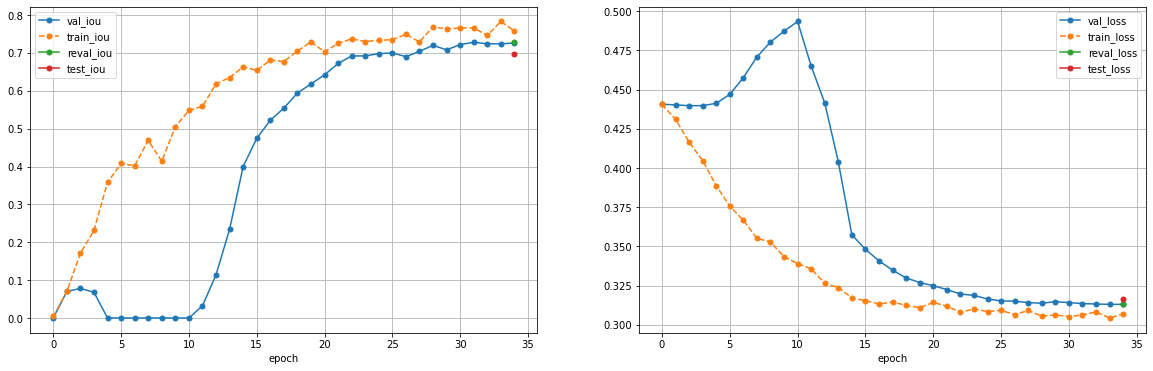

Global seed set to 17


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 17


In [31]:
class SegmentationSegNetIOU(SegmentationTask):
    def __init__(self, hparams):
        model = SegNet()
        criterion = CustomLoss(iou_loss)
        super().__init__(hparams, model, criterion)


best_result = runner.run_single_trial(
    SegmentationSegNetIOU, CONFIG, TUNE_CONFIG
)

## Combo loss
According to 
- ["A survey of loss functions for semantic segmentation",  Shruti Jadon, 2020](https://arxiv.org/pdf/2006.14822.pdf) 

a combo loss of Dice and BCE can be useful for slightly-unbalanced segnemtation problems to improve the results. Let us add our custom IOU to this combo:

In [32]:
def combo_loss(y_hat, y):
    return dice_loss(y_hat, y) + iou_loss(y_hat, y) + bce_loss(y_hat, y)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 17
Global seed set to 17

  | Name              | Type           | Params
-----------------------------------------------------
0 | model             | SegNet         | 9.2 M 
1 | criterion         | CustomLoss     | 0     
2 | train_metric_calc | LitMetricsCalc | 0     
3 | val_metric_calc   | LitMetricsCalc | 0     
4 | test_metric_calc  | LitMetricsCalc | 0     
-----------------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

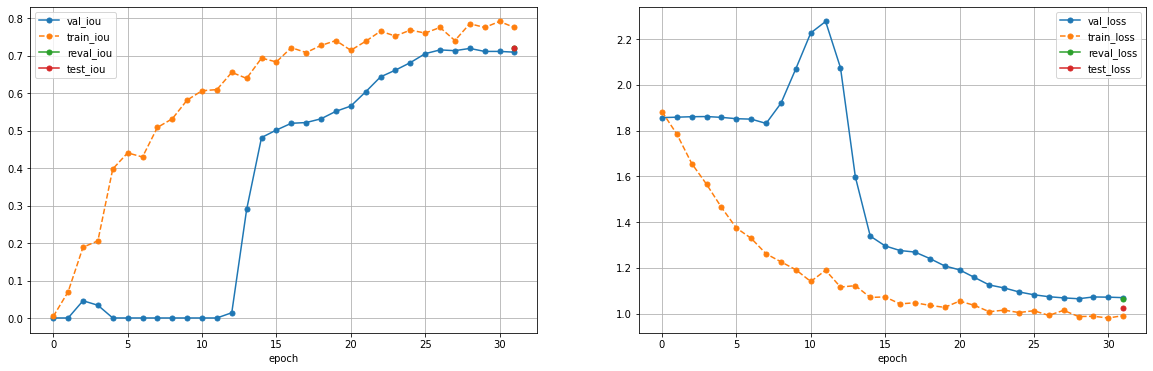

Global seed set to 17


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 17


In [33]:
class SegmentationSegNetCombo(SegmentationTask):
    def __init__(self, hparams):
        model = SegNet()
        criterion = CustomLoss(combo_loss)
        super().__init__(hparams, model, criterion)


best_result = runner.run_single_trial(
    SegmentationSegNetCombo, CONFIG, TUNE_CONFIG
)

# Lovasz-Softmax loss 

* ["The Lovasz-Softmax loss: A tractable surrogate for the optimization of theintersection-over-union measure in neural networks" by Maxim Berman, Amal Rannen Triki,  Matthew B. BlaschkoDept, ESAT, Center for Processing Speech and ImagesKU Leuven, Belgium](https://openaccess.thecvf.com/content_cvpr_2018/papers/Berman_The_LovaSz-Softmax_Loss_CVPR_2018_paper.pdf)

In [34]:
def lovasz_hinge_loss(y_pred, y_real):
    """
    Binary Lovasz hinge loss
    """
    loss = torch.mean(
        torch.stack(
            list(
                lovasz_hinge_flat_loss(
                    y_r.unsqueeze(0).view(-1), y_p.unsqueeze(0).view(-1)
                )
                for y_r, y_p in zip(y_real.squeeze(), y_pred.squeeze())
            )
        )
    )
    return loss


def lovasz_hinge_flat_loss(y_real, y_pred):
    if len(y_real) == 0:
        return y_pred.sum() * 0.0
    signs = 2.0 * y_real.float() - 1.0
    errors = 1.0 - y_pred * signs
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = y_real[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), grad)
    return loss


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Algorithm 1 from https://openaccess.thecvf.com/content_cvpr_2018/papers/Berman_The_LovaSz-Softmax_Loss_CVPR_2018_paper.pdf, pp. 4416
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1.0 - intersection / union
    if p > 1:
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 17
Global seed set to 17

  | Name              | Type                  | Params
------------------------------------------------------------
0 | model             | SegNet                | 9.2 M 
1 | criterion         | CustomLossWithSqueeze | 0     
2 | train_metric_calc | LitMetricsCalc        | 0     
3 | val_metric_calc   | LitMetricsCalc        | 0     
4 | test_metric_calc  | LitMetricsCalc        | 0     
------------------------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

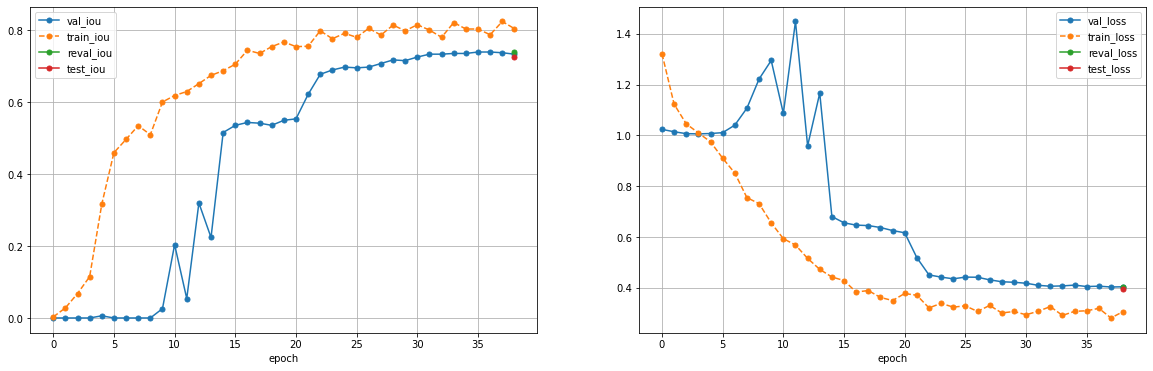

Global seed set to 17


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 17


In [35]:
class CustomLossWithSqueeze(nn.Module):
    def __init__(self, f_loss):
        super().__init__()

        self.f_loss = f_loss

    def forward(self, logits, targets):
        return self.f_loss(logits.squeeze(), targets.squeeze())


class SegmentationSegNetLovasz(SegmentationTask):
    def __init__(self, hparams):
        model = SegNet()
        criterion = CustomLossWithSqueeze(lovasz_hinge_loss)
        super().__init__(hparams, model, criterion)


best_result = runner.run_single_trial(
    SegmentationSegNetLovasz, CONFIG, TUNE_CONFIG
)

-----------------------------------------------------------------------------------------

# U-Net

- ["U-Net: Convolutional Networks for Biomedical Image Segmentation" by Olaf Ronneberger, Philipp Fischer, Thomas Brox, Springer, Cham, 2015](https://arxiv.org/abs/1505.04597) 

What makes UNet different from SegNet is presence of skip-connections and a symmetrical nature of the network


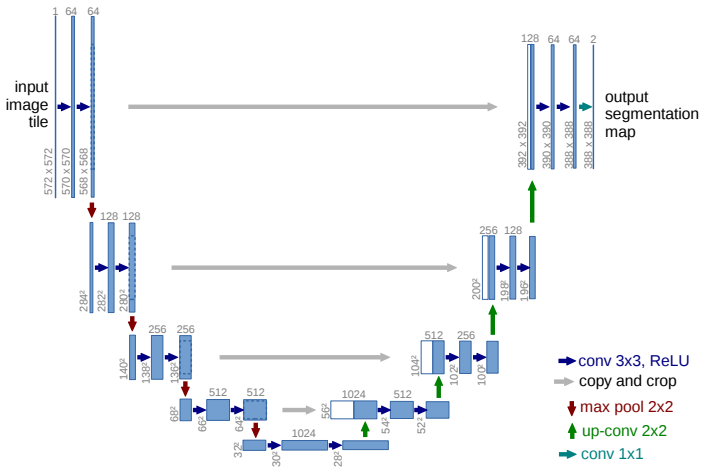

In [36]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=64, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=64, out_channels=128, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128, out_channels=128, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=256, out_channels=256, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=512, out_channels=512, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(
            scale_factor=2, mode="bilinear", align_corners=True
        )  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(
                in_channels=1024, out_channels=256, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=256, out_channels=256, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample1 = nn.Upsample(
            scale_factor=2, mode="bilinear", align_corners=True
        )  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=128, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128, out_channels=128, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.upsample2 = nn.Upsample(
            scale_factor=2, mode="bilinear", align_corners=True
        )  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=64, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.upsample3 = nn.Upsample(
            scale_factor=2, mode="bilinear", align_corners=True
        )  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=64, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=(3, 3), padding=(1, 1)
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.dec_conv0(torch.cat([self.upsample0(b), e3], dim=1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0), e2], dim=1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1), e1], dim=1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], dim=1))  # no activation
        return d3

In [37]:
CONFIG = {
    "lr": 3e-4,  # Initial learning rate
    "lr_step_epochs": 7,  # for StepLR LR scheduler
    "lr_step_factor": 0.08,  # for StepLR LR scheduler
    "gradient_clip_val": 0,
    "max_epochs": 30,  # the actual number can be less due to early stopping
    "batch_size": 12,  # the maximum for this model and RTX 2070,
}

TUNE_CONFIG = {
    "seed": 16,
    "metric_to_optimize": "val_iou_epoch",  # Ray + PTL Trainer
    "ray_metrics_to_show": [
        "val_loss_epoch",
        "val_iou_epoch",
    ],  # Ray
    "metric_opt_mode": "max",  # Ray + PTL Trainer
    "cpu_per_trial": NUM_WORKERS,  # Ray + DataLoaders
    "gpu_per_trial": 0.5,  # Ray
    "n_checkpoints_to_keep": 1,  # Ray
    "epoch_upper_limit": 45,  # Ray
    "n_samples": 40,  # Ray
    # "n_samples": 3,
    "ptl_early_stopping_patience": 5,  # PTL Trainer
    "grace_period": 8,  # PTL Trainer
    "ptl_precision": 16,  # PTL Trainer
    # "ptl_precision": 32,  # PTL Trainer
    #
    "train_loader_name": "train",
    "val_loader_name": "valid",
    "test_loader_name": "test",
    #
    "batch_size_main": CONFIG[
        "batch_size"
    ],  # batch size for validation runs in the main process once all Ray Tune trials are finished
    "gpus": 1,
}

if FAST_DEV_RUN:
    CONFIG["max_epochs"] = 2
    TUNE_CONFIG["n_samples"] = 2
    TUNE_CONFIG["gpu_per_trial"] = 0.5

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16

  | Name              | Type           | Params
-----------------------------------------------------
0 | model             | UNet           | 18.1 M
1 | criterion         | CustomLoss     | 0     
2 | train_metric_calc | LitMetricsCalc | 0     
3 | val_metric_calc   | LitMetricsCalc | 0     
4 | test_metric_calc  | LitMetricsCalc | 0     
-----------------------------------------------------
18.1 M    Trainable params
0         Non-trainable params
18.1 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

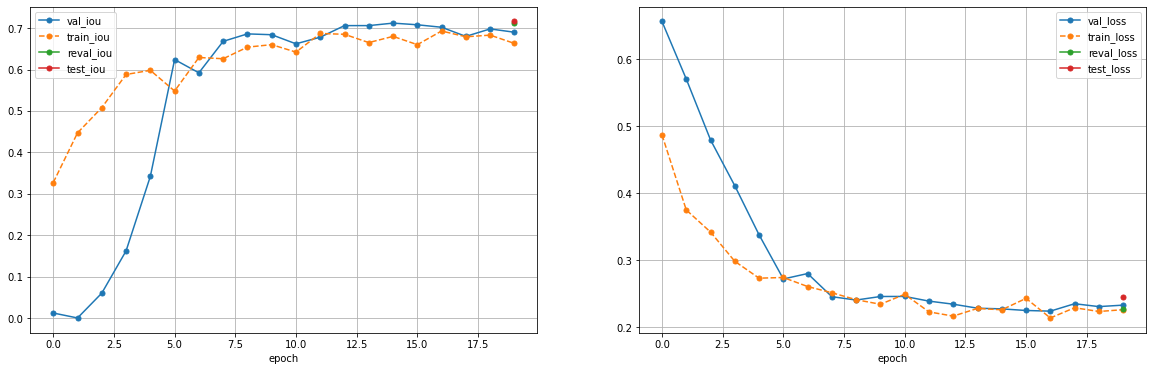

Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [38]:
class SegmentationUNetBCE(SegmentationTask):
    def __init__(self, hparams):
        model = UNet()
        criterion = CustomLoss(bce_loss)
        super().__init__(hparams, model, criterion)


best_result = runner.run_single_trial(
    SegmentationUNetBCE, CONFIG, TUNE_CONFIG
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16

  | Name              | Type           | Params
-----------------------------------------------------
0 | model             | UNet           | 18.1 M
1 | criterion         | CustomLoss     | 0     
2 | train_metric_calc | LitMetricsCalc | 0     
3 | val_metric_calc   | LitMetricsCalc | 0     
4 | test_metric_calc  | LitMetricsCalc | 0     
-----------------------------------------------------
18.1 M    Trainable params
0         Non-trainable params
18.1 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

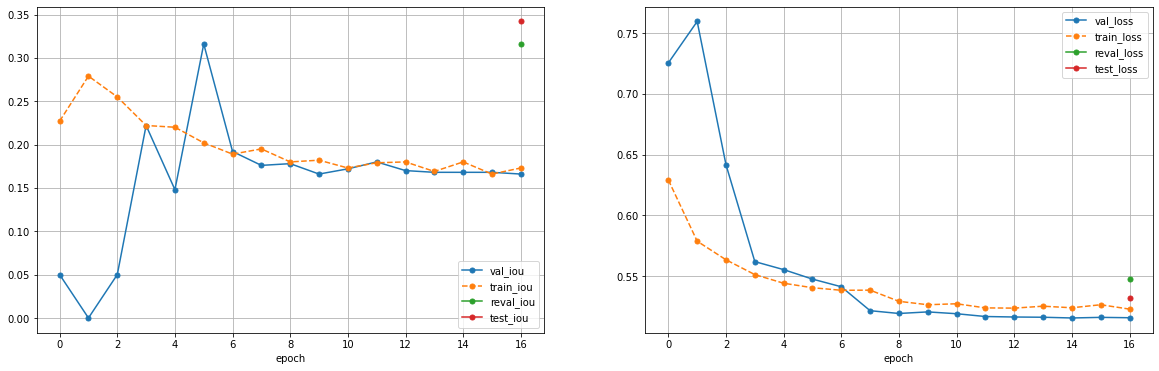

Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [39]:
class SegmentationUNetDice(SegmentationTask):
    def __init__(self, hparams):
        model = UNet()
        criterion = CustomLoss(dice_loss)
        super().__init__(hparams, model, criterion)


best_result = runner.run_single_trial(
    SegmentationUNetDice, CONFIG, TUNE_CONFIG
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16

  | Name              | Type           | Params
-----------------------------------------------------
0 | model             | UNet           | 18.1 M
1 | criterion         | CustomLoss     | 0     
2 | train_metric_calc | LitMetricsCalc | 0     
3 | val_metric_calc   | LitMetricsCalc | 0     
4 | test_metric_calc  | LitMetricsCalc | 0     
-----------------------------------------------------
18.1 M    Trainable params
0         Non-trainable params
18.1 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

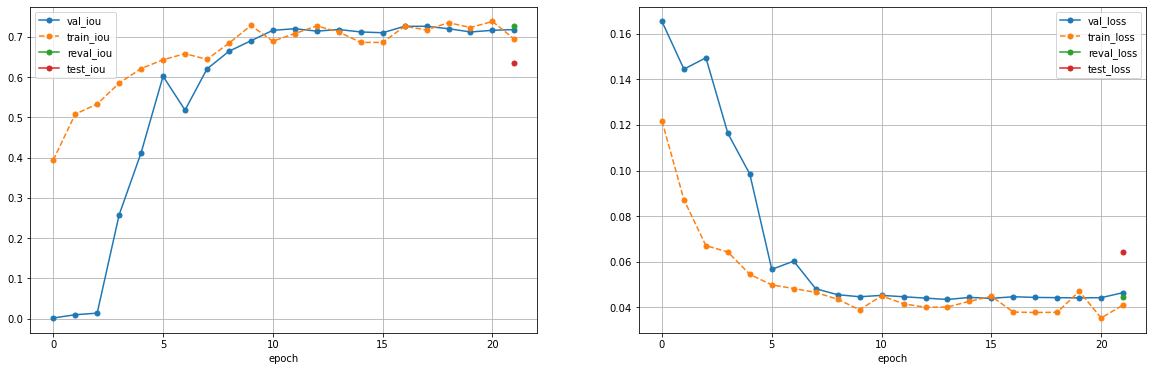

Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [40]:
class SegmentationUNetFocal(SegmentationTask):
    def __init__(self, hparams):
        model = UNet()
        criterion = CustomLoss(focal_loss)
        super().__init__(hparams, model, criterion)


best_result = runner.run_single_trial(
    SegmentationUNetFocal, CONFIG, TUNE_CONFIG
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16

  | Name              | Type           | Params
-----------------------------------------------------
0 | model             | UNet           | 18.1 M
1 | criterion         | CustomLoss     | 0     
2 | train_metric_calc | LitMetricsCalc | 0     
3 | val_metric_calc   | LitMetricsCalc | 0     
4 | test_metric_calc  | LitMetricsCalc | 0     
-----------------------------------------------------
18.1 M    Trainable params
0         Non-trainable params
18.1 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

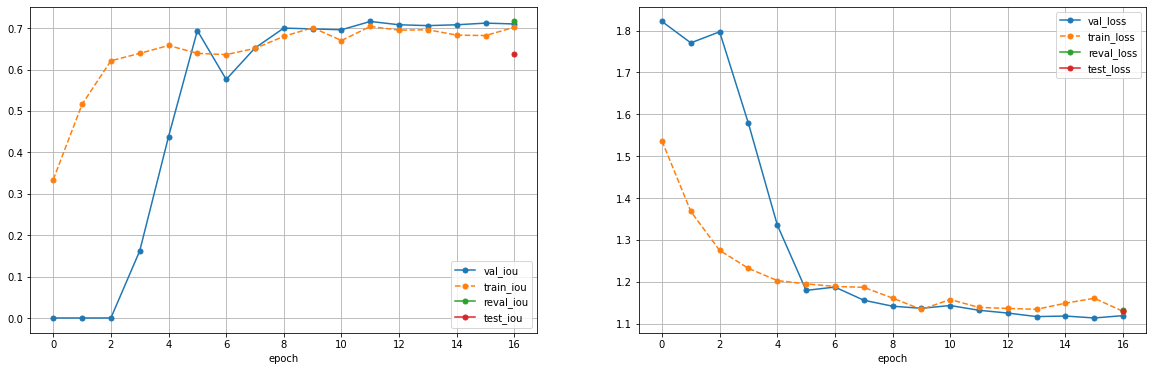

Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [41]:
class SegmentationUNetCombo(SegmentationTask):
    def __init__(self, hparams):
        model = UNet()
        criterion = CustomLoss(combo_loss)
        super().__init__(hparams, model, criterion)


best_result = runner.run_single_trial(
    SegmentationUNetCombo, CONFIG, TUNE_CONFIG
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16

  | Name              | Type                  | Params
------------------------------------------------------------
0 | model             | UNet                  | 18.1 M
1 | criterion         | CustomLossWithSqueeze | 0     
2 | train_metric_calc | LitMetricsCalc        | 0     
3 | val_metric_calc   | LitMetricsCalc        | 0     
4 | test_metric_calc  | LitMetricsCalc        | 0     
------------------------------------------------------------
18.1 M    Trainable params
0         Non-trainable params
18.1 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

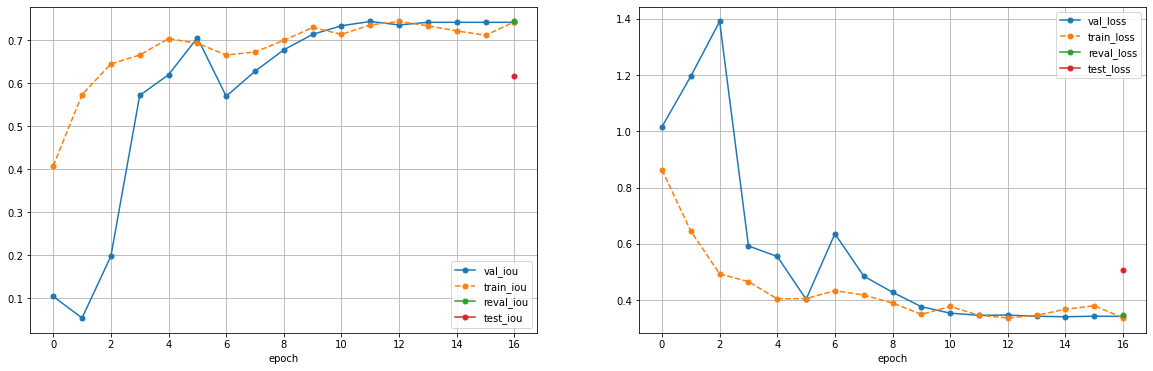

Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [42]:
class SegmentationUNetLovasz(SegmentationTask):
    def __init__(self, hparams):
        model = UNet()
        criterion = CustomLossWithSqueeze(lovasz_hinge_loss)
        super().__init__(hparams, model, criterion)


best_result = runner.run_single_trial(
    SegmentationUNetLovasz, CONFIG, TUNE_CONFIG
)

# Modified U-Net

Let us see if it helps to change max-pooling to convolutions with stride=2 and upsampling - to transpose-convolutions with stride=2

In [43]:
class UNet2(UNet):
    def __init__(self):
        super().__init__()
        self.pool0 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=(3, 3),
            stride=2,
            padding=(1, 1),
        )  # 256 -> 128
        self.pool1 = nn.Conv2d(
            in_channels=128,
            out_channels=128,
            kernel_size=(3, 3),
            stride=2,
            padding=(1, 1),
        )  # 128 -> 64
        self.pool2 = nn.Conv2d(
            in_channels=256,
            out_channels=256,
            kernel_size=(3, 3),
            stride=2,
            padding=(1, 1),
        )  # 64 -> 32
        self.pool3 = nn.Conv2d(
            in_channels=512,
            out_channels=512,
            kernel_size=(3, 3),
            stride=2,
            padding=(1, 1),
        )  # 32 -> 16

        self.upsample0 = nn.ConvTranspose2d(
            in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=(1, 1)
        )  # 16 -> 32
        self.upsample1 = nn.ConvTranspose2d(
            in_channels=256, out_channels=256, kernel_size=4, stride=2, padding=(1, 1)
        )  # 32 -> 64
        self.upsample2 = nn.ConvTranspose2d(
            in_channels=128, out_channels=128, kernel_size=4, stride=2, padding=(1, 1)
        )  # 64 -> 128
        self.upsample3 = nn.ConvTranspose2d(
            in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=(1, 1)
        )  # 128 -> 256

In [44]:
CONFIG = {
    "lr": 2e-4,  # Initial learning rate
    "lr_step_epochs": 7,  # for StepLR LR scheduler
    "lr_step_factor": 0.1,  # for StepLR LR scheduler
    "gradient_clip_val": 0,
    "max_epochs": 30,  # the actual number can be less due to early stopping
    "batch_size": 12,  # the maximum for this model and RTX 2070,
}

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16

  | Name              | Type           | Params
-----------------------------------------------------
0 | model             | UNet2          | 26.8 M
1 | criterion         | CustomLoss     | 0     
2 | train_metric_calc | LitMetricsCalc | 0     
3 | val_metric_calc   | LitMetricsCalc | 0     
4 | test_metric_calc  | LitMetricsCalc | 0     
-----------------------------------------------------
26.8 M    Trainable params
0         Non-trainable params
26.8 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

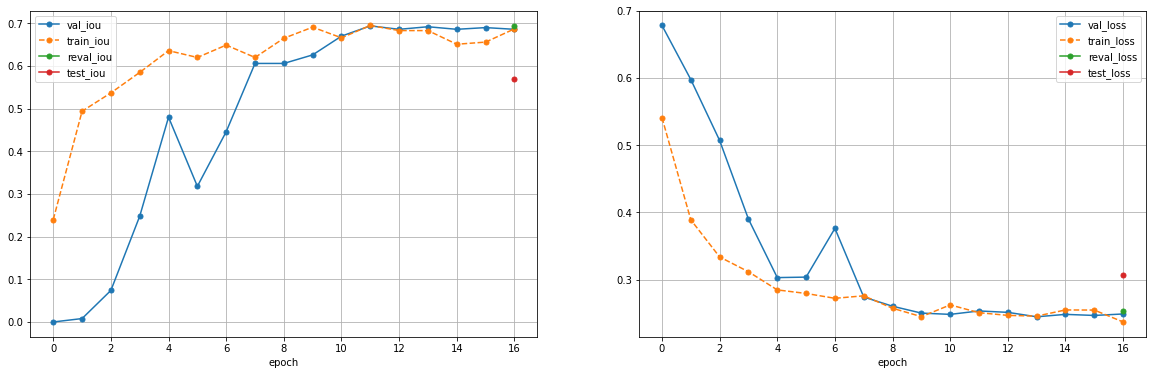

Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [45]:
class SegmentationUNet2BCE(SegmentationTask):
    def __init__(self, hparams):
        model = UNet2()
        criterion = CustomLoss(bce_loss)
        super().__init__(hparams, model, criterion)


best_result = runner.run_single_trial(
    SegmentationUNet2BCE, CONFIG, TUNE_CONFIG
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16

  | Name              | Type           | Params
-----------------------------------------------------
0 | model             | UNet2          | 26.8 M
1 | criterion         | CustomLoss     | 0     
2 | train_metric_calc | LitMetricsCalc | 0     
3 | val_metric_calc   | LitMetricsCalc | 0     
4 | test_metric_calc  | LitMetricsCalc | 0     
-----------------------------------------------------
26.8 M    Trainable params
0         Non-trainable params
26.8 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

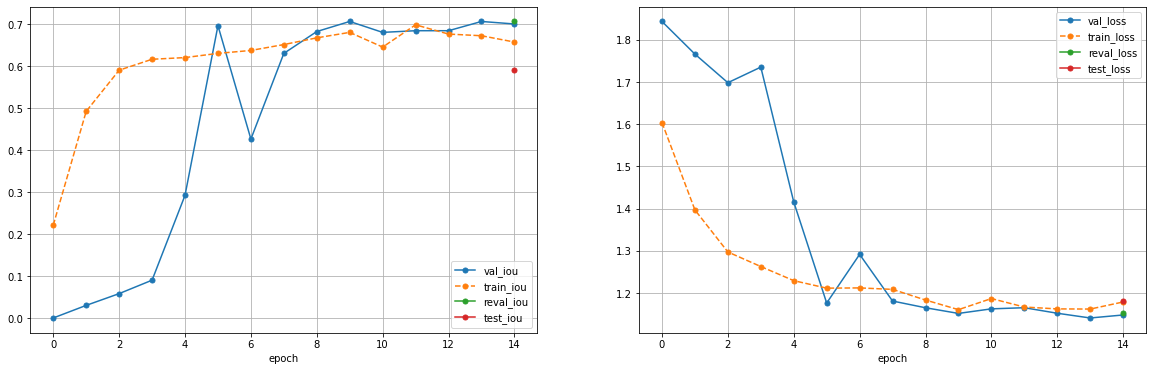

Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [46]:
class SegmentationUNet2Combo(SegmentationTask):
    def __init__(self, hparams):
        model = UNet2()
        criterion = CustomLoss(combo_loss)
        super().__init__(hparams, model, criterion)


best_result = runner.run_single_trial(
    SegmentationUNet2Combo, CONFIG, TUNE_CONFIG
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16

  | Name              | Type           | Params
-----------------------------------------------------
0 | model             | UNet2          | 26.8 M
1 | criterion         | CustomLoss     | 0     
2 | train_metric_calc | LitMetricsCalc | 0     
3 | val_metric_calc   | LitMetricsCalc | 0     
4 | test_metric_calc  | LitMetricsCalc | 0     
-----------------------------------------------------
26.8 M    Trainable params
0         Non-trainable params
26.8 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

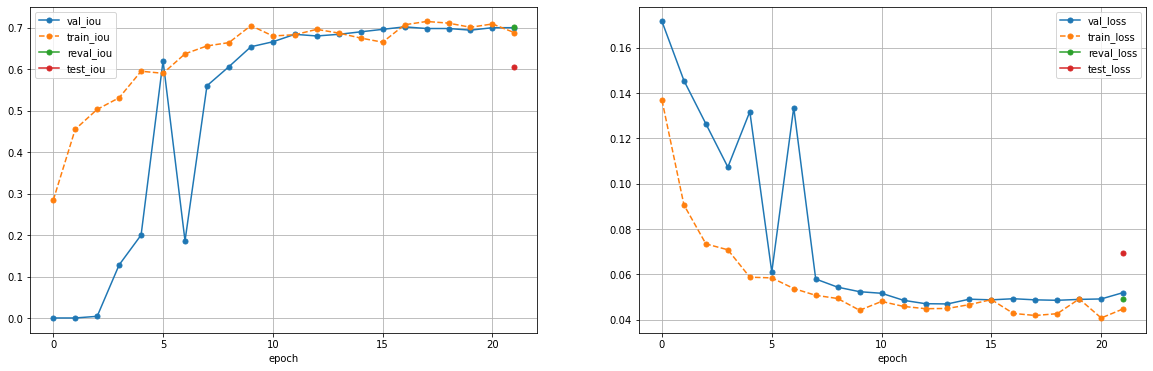

Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [47]:
class SegmentationUNet2Focal(SegmentationTask):
    def __init__(self, hparams):
        model = UNet2()
        criterion = CustomLoss(focal_loss)
        super().__init__(hparams, model, criterion)


best_result = runner.run_single_trial(
    SegmentationUNet2Focal, CONFIG, TUNE_CONFIG
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16

  | Name              | Type                  | Params
------------------------------------------------------------
0 | model             | UNet2                 | 26.8 M
1 | criterion         | CustomLossWithSqueeze | 0     
2 | train_metric_calc | LitMetricsCalc        | 0     
3 | val_metric_calc   | LitMetricsCalc        | 0     
4 | test_metric_calc  | LitMetricsCalc        | 0     
------------------------------------------------------------
26.8 M    Trainable params
0         Non-trainable params
26.8 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

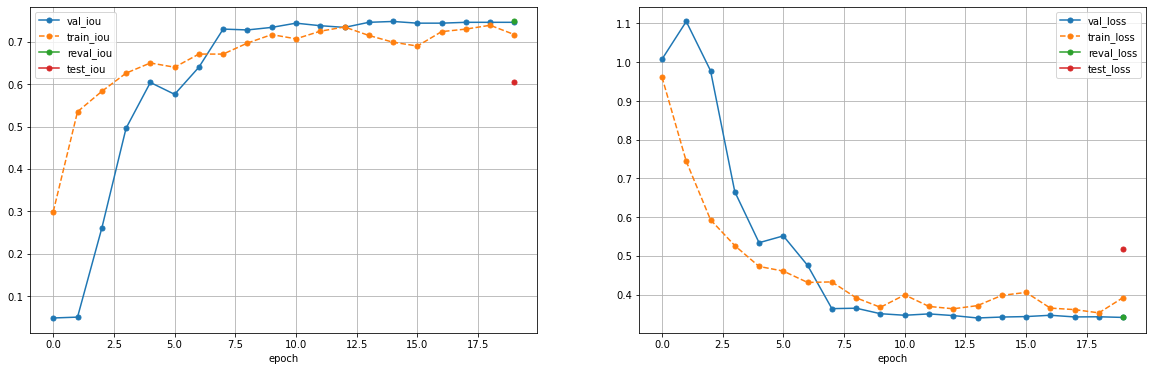

Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [48]:
class SegmentationUNet2Lovasz(SegmentationTask):
    def __init__(self, hparams):
        model = UNet2()
        criterion = CustomLossWithSqueeze(lovasz_hinge_loss)
        super().__init__(hparams, model, criterion)


best_result = runner.run_single_trial(
    SegmentationUNet2Lovasz, CONFIG, TUNE_CONFIG
)

### Final set of graphs and performance statistics on validation and test sets

,test_iou,run
40,0.726,single-trial-SegmentationSegNetLovasz
33,0.722,single-trial-SegmentationSegNetCombo
21,0.716,single-trial-SegmentationUNetBCE
36,0.696,single-trial-SegmentationSegNetIOU
37,0.686,single-trial-SegmentationSegNetFocal
33,0.684,single-trial-SegmentationSegNetBCE
18,0.638,single-trial-SegmentationUNetCombo
23,0.634,single-trial-SegmentationUNetFocal
18,0.618,single-trial-SegmentationUNetLovasz
23,0.606,single-trial-SegmentationUNet2Focal


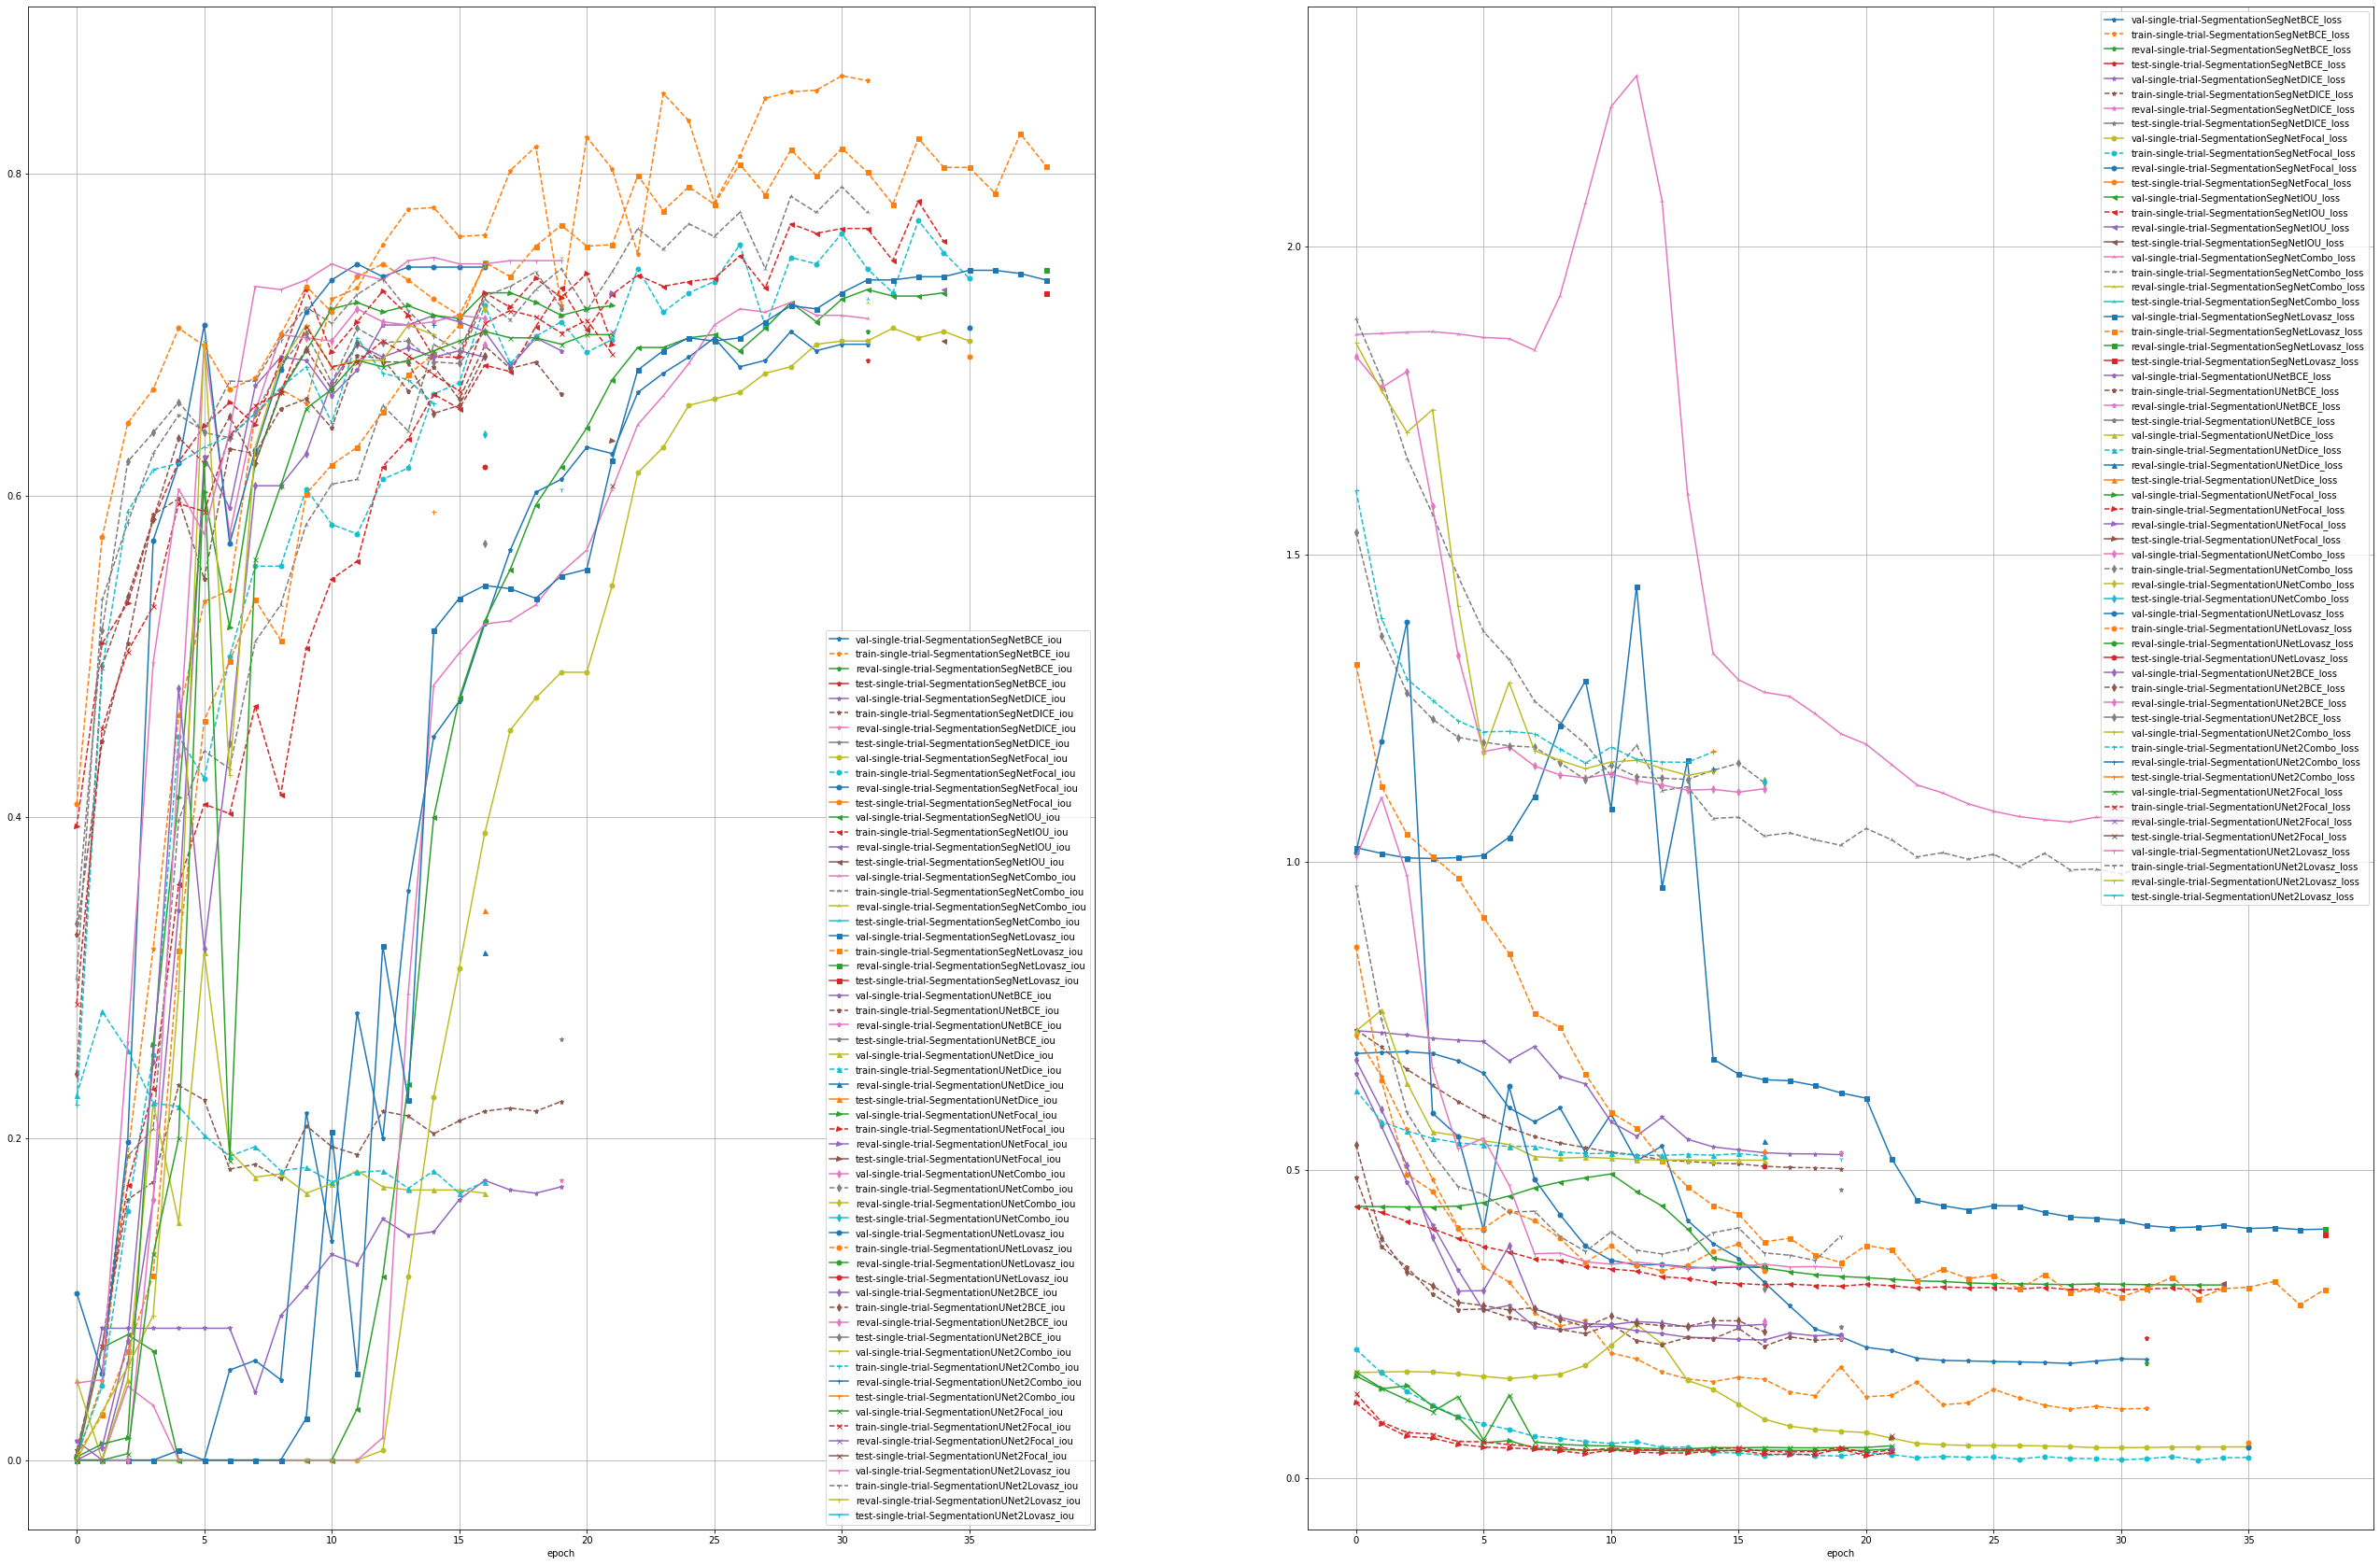

In [49]:
runner.show_metric_report(sort_by_metric_list=['test_iou'], figsize=(45, 30))